# Previsão de renda de clientes:

## 1. Introdução:

O objetivo deste projeto é desenvolver um modelo preditivo capaz de estimar a renda de clientes a partir de informações socioeconômicas.

Essa previsão pode ser utilizada para definir limites de crédito, oferecer produtos financeiros adequados e mitigar riscos de inadimplência.

A previsão de renda é útil pra diversas instituições financeiras, tal informação pode guiar em desisões como o valor máximo de empréstimos concedidos, limite de crédito para um cliente, também como produtos financeiros adequados e mitigar riscos de inadimplência. Utilizando a base de dados que contém as informações socioeconômicas dos clientes, é possível realizar a análise de como tais informações se relacionam com a renda apresentada para assim criar o modelo adequado para previsões de futuros clientes.


A base de dados utilizada neste projeto foi disponibilizada pela EBAC no curso de Ciência de Dados. 


Dicionário de dados:


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data do cadastro                                 | object  |
| id_cliente              |  Identificador único do cliente                   | int64   |
| sexo                    |  Sexo F ou M                                      | object  |
| posse_de_veiculo        |  Classifica se possui ou não veículo              | bool    |
| posse_de_imovel         |  Classifica se possui ou não imóvel               | bool    |
| qtd_filhos              |  Quantidade de filhos do cliente                  | int64   |
| tipo_renda              |  Fonte da renda do cliente                        | object  |
| educacao                |  Grau de educação formal do cliente               | object  |
| estado_civil            |  Estado civil do cliente                          | object  |
| tipo_residencia         |  Tipo de residência do cliente                    | object  |
| idade                   |  Idade do cliente                                 | int64   |
| tempo_emprego           |  Tempo (anos) em que o cliente está empregado     | float64 |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência do cliente   | int64   |
| renda                   |  Renda total                                      | float64 |





## 2. Importação de Bibliotecas:

Bibliotecas utilizadas:

In [281]:
# Bibliotecas principais
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from scipy.stats import uniform, randint

# Machine Learning
import optuna
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor

# Avaliação 
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [282]:
%matplotlib inline

## 3. Carregamento dos Dados:

In [283]:
renda = pd.read_csv('previsao_de_renda.csv')

In [284]:
renda.sample(5)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
6309,6309,2015-07-01,7722,F,False,True,0,Empresário,Superior completo,União,Casa,24,0.934247,2.0,1051.20
8306,8306,2015-09-01,4765,F,False,True,1,Assalariado,Superior completo,Casado,Casa,43,24.117808,3.0,2847.56
1797,1797,2015-02-01,2745,F,False,True,0,Assalariado,Secundário,Casado,Casa,43,8.312329,2.0,1906.94
11683,11683,2015-12-01,14076,M,False,False,0,Assalariado,Secundário,Casado,Casa,57,32.558904,2.0,58235.68
7507,7507,2015-08-01,723,F,True,True,0,Assalariado,Secundário,Casado,Casa,35,4.526027,2.0,3764.79


In [285]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

Aqui já é possível identificar que o dataframe possui missing values.

In [286]:
renda.describe()

,Unnamed: 0,id_cliente,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,15000.000000,15000.000000,15000.000000,15000.000000,12427.000000,15000.000000,15000.000000
mean,7499.500000,8304.871400,0.432333,43.882333,7.722635,2.206400,5697.287057
std,4330.271354,4797.780446,0.746631,11.273155,6.711189,0.909792,8266.816289
min,0.000000,1.000000,0.000000,22.000000,0.117808,1.000000,118.710000
25%,3749.750000,4181.000000,0.000000,34.000000,2.973973,2.000000,2026.110000
50%,7499.500000,8297.000000,0.000000,43.000000,6.013699,2.000000,3499.720000
75%,11249.250000,12403.000000,1.000000,53.000000,10.120548,3.000000,6392.167500
max,14999.000000,16649.000000,14.000000,68.000000,42.906849,15.000000,245141.670000


Para as variáveis numéricas:
-  `qtd_filhos` com o valor máximo de 14 e mínimo de 0 e sua média de 0.43
- `idade` com o valor máximo de 68 anos e mínimo de 22 anos e sua média de 43 anos
- `tempo_emprego` com o valor máximo de 42 anos e mínimo de 0.11 ano e sua média de 7 anos
- `qt_pessoas_residencia` com o valor máximo de 15 e mínimo de 1 e sua média de 2
- `renda` com o valor máximo de 245141.67 e mínimo de 118.71 e sua média de 5697

## 4. Análise Exploratória dos Dados (EDA):

Nessa etapa vamos entender melhor o comportamento dos dados e suas principais características.

- Análise de valores nulos
- Distribuição das variáveis
- Correlação entre variáveis
- Boxplots para detectar outliers (se necessário)

In [287]:
prof = ProfileReport(renda, explorative=True, minimal=True)

In [288]:
prof.to_file('./output/renda_analisys.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1 Análise dos valores nulos:

Criação de um DataFrame com os metadados da base de dados utilizada:

In [289]:
metadados = pd.DataFrame({'dtypes': renda.dtypes})
metadados['missing'] = renda.isna().sum()
metadados['perc_missing'] = round((metadados['missing']/renda.shape[0])*100)
metadados['valores_unicos'] = renda.nunique()
metadados

,dtypes,missing,perc_missing,valores_unicos
Unnamed: 0,int64,0,0.0,15000
data_ref,object,0,0.0,15
id_cliente,int64,0,0.0,9845
sexo,object,0,0.0,2
posse_de_veiculo,bool,0,0.0,2
posse_de_imovel,bool,0,0.0,2
qtd_filhos,int64,0,0.0,8
tipo_renda,object,0,0.0,5
educacao,object,0,0.0,5
estado_civil,object,0,0.0,5


A partir da tabela acima é possível identificar que a única feature com missing values é `tempo_emprego`, com o valor de 2573 que representa 17% da totalidade dos dados para aquela feature.

### 4.2 Distribuição das variáveis:

Função para criação do gráfico da distribuição das variáveis qualitativas:

In [290]:
def countplot(var:str):
    '''
    Recebe uma variável qualitativa e retorna sua distribuição por categoria
    '''
    ordem = renda[var].value_counts().index
    ax = sns.countplot(renda, x=var, hue=var, palette='crest', order=ordem,legend=False)
    for i in range(renda[var].nunique()):
        ax.bar_label(ax.containers[i], fontsize=10)
    plt.ylabel('Quantidade')
    plt.xlabel(var.capitalize())
    plt.xticks(rotation=45)
    plt.title(f'Distribuição da Quantidade por {var.capitalize()}')
    plt.tight_layout()
    plt.show()
    
    contagem = renda[var].value_counts()
    porcentagem = (contagem / contagem.sum()) * 100
    print(f'Porcentagem por categoria: \n {porcentagem}')

Função para criação do gráfico da distribuição das variáveis contínuas:

In [291]:
def histplot(var:str):
    ''' 
    Recebe uma variável numérica e retorna sua distribuição
    '''
    plt.figure(figsize=(10,6))
    if var == 'tempo_emprego':
        sns.histplot(renda, x=var, kde=True, color= sns.color_palette('crest')[1])
    else:
        sns.histplot(renda, x=var, discrete=True, color= sns.color_palette('crest')[1])
    plt.ylabel('Quantidade')
    plt.xlabel(var.capitalize())
    plt.title(f'Distribuição da Quantidade por {var.capitalize()}')
    plt.tight_layout()
    plt.show()

Distribuição da variável alvo e análise de suas características:

Text(0, 0.5, 'Contagem')

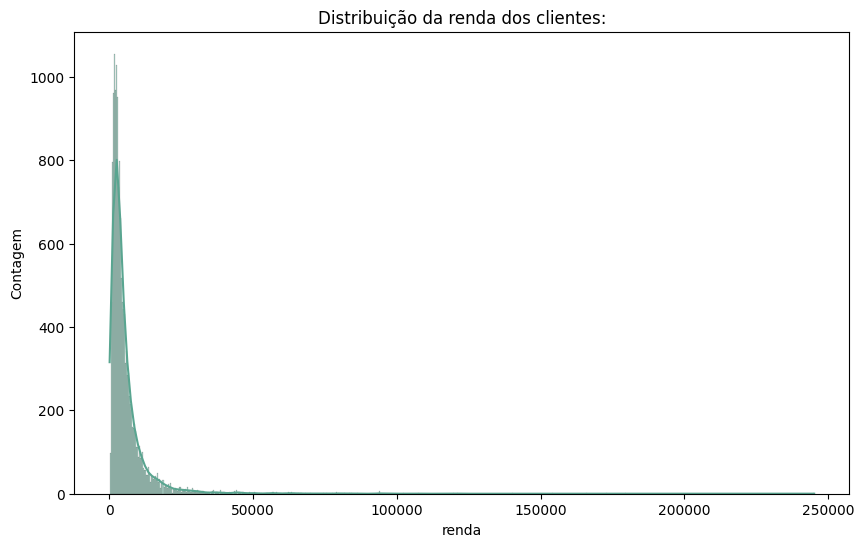

In [292]:
plt.figure(figsize=(10,6))
sns.histplot(data=renda,
            x='renda', 
            kde=True,
            color= sns.color_palette('crest')[1]
            )
plt.title('Distribuição da renda dos clientes:')
plt.ylabel('Contagem')

A variável renda apresenta característica de descrescimento logarítmico. Para um entendimento melhor da sua característica e distribuição, é valido aplicar a função log na mesma. 

É possível concluir que a maioria dos clientes possuem rendas baixas e poucos tem rendas muitos alteas.

Aplicando o log na `renda`.

Text(0, 0.5, 'Contagem')

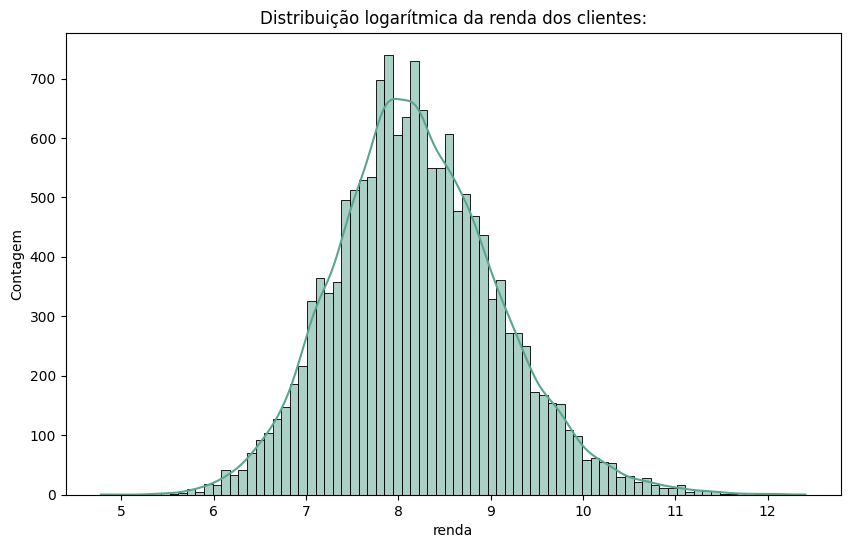

In [293]:
plt.figure(figsize=(10,6))
sns.histplot(data=renda, 
             x=np.log(renda['renda']),
             kde=True,
             color= sns.color_palette('crest')[1]
             )
plt.title('Distribuição logarítmica da renda dos clientes:')
plt.ylabel('Contagem')

Desta forma, a distribuição da variável renda se apresenta de forma mais simetrica, semelhante a uma normal, facilitando a análise para futura modelagem. 

É possível identificar que a maior concentração de clientes está na faixa de 7 a 9, tendo o seu pico no 8. Como $e^8$ = 2980 reais, representa o valor proxímo de renda que mais aparece na base de dados.

#### 4.2.1 Distribuição das variáveis qualitativas:

As variáveis utilizadas para análise univariada aqui serão:
- `sexo`
- `posse_de_veiculo`
- `tipo_renda`
- `educacao`
- `estado_civil`
- `tipo_residencia`

##### Distribuição variável `sexo`:

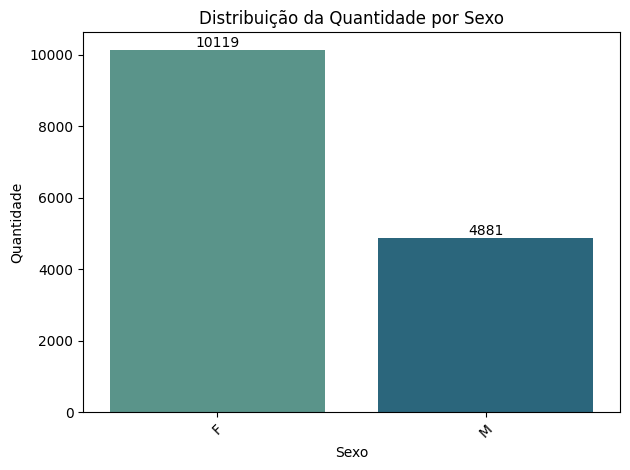

Porcentagem por categoria: 
 sexo
F    67.46
M    32.54
Name: count, dtype: float64


In [294]:
countplot('sexo')

O sexo feminino é aquele com maior quantidade dentre os clientes, com 10119 registros, enquanto o sexo masculino conta com 4881 registros. Representando 67.46% e 32.54% respectivamente.

##### Distribuição variável `posse_de_veiculo`:

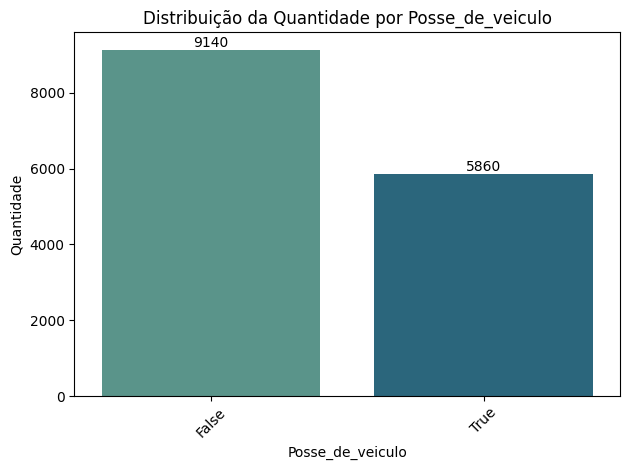

Porcentagem por categoria: 
 posse_de_veiculo
False    60.933333
True     39.066667
Name: count, dtype: float64


In [295]:
countplot('posse_de_veiculo')

Aqueles que não possuem veículo são a maior categoria, com 9140 registros representando 60.93%. Enquanto aqueles que possuem contam com 5860 registros, representando 39.06%.

##### Distribuição da variável `posse_de_imovel`:

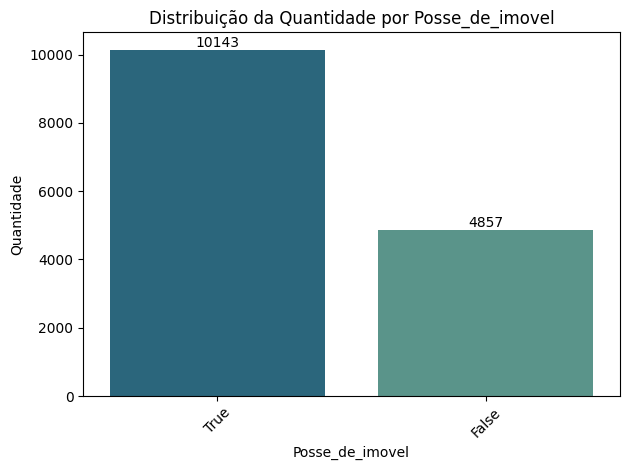

Porcentagem por categoria: 
 posse_de_imovel
True     67.62
False    32.38
Name: count, dtype: float64


In [296]:
countplot('posse_de_imovel')

Os clientes que possuem imóvel são maioria e representam 10143, enquanto os que não possuem representam 4857. Com porcentagem de 67.62% e 32.38% respectivamente.

##### Distribuição da variável `tipo_renda`:

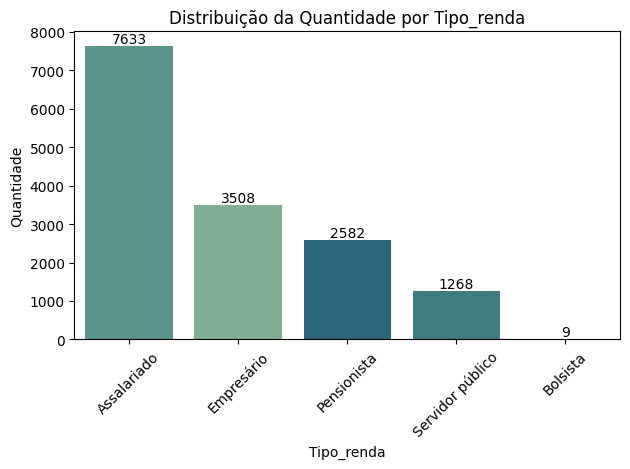

Porcentagem por categoria: 
 tipo_renda
Assalariado         50.886667
Empresário          23.386667
Pensionista         17.213333
Servidor público     8.453333
Bolsista             0.060000
Name: count, dtype: float64


In [297]:
countplot('tipo_renda')

Das categorias acima a com mais clientes é Assalariado com 7633 registros, representando 50.8% do total. Seguido de Empresário (3508 registros, 23.3%), Pensionista (2582 registros, 17.2%), Servidor Público (1268 registros, 8.4%) e Bolsista(9 registros, 0.06%).

##### Distribuição da variável `educacao`:

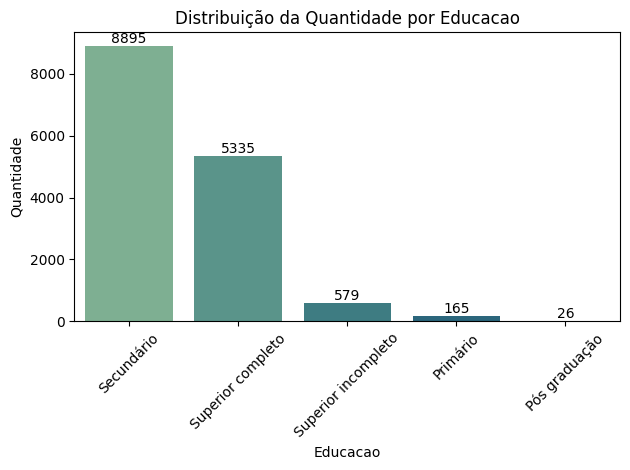

Porcentagem por categoria: 
 educacao
Secundário             59.300000
Superior completo      35.566667
Superior incompleto     3.860000
Primário                1.100000
Pós graduação           0.173333
Name: count, dtype: float64


In [298]:
countplot('educacao')

A maior categoria é Secundário (8895 registros, 59.3%), seguida por Superior Completo (5335 registros, 35.5%), Superior Incompleto (579 registros, 3.8%), Primário (165 registros, 1.1%) e Pós Graduação(26 registros, 0.17%).

##### Distribuição da variável `estado_civil`:

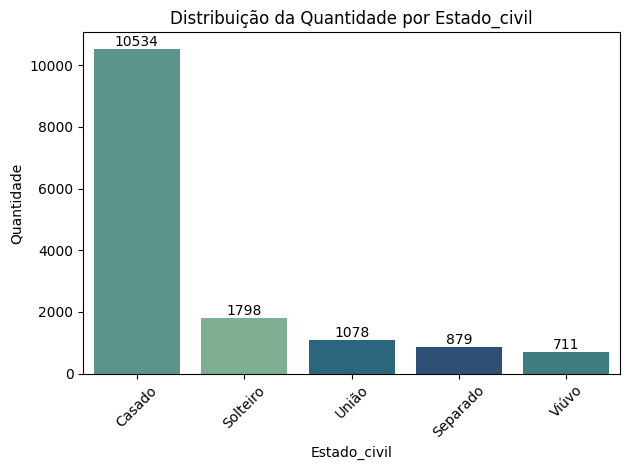

Porcentagem por categoria: 
 estado_civil
Casado      70.226667
Solteiro    11.986667
União        7.186667
Separado     5.860000
Viúvo        4.740000
Name: count, dtype: float64


In [299]:
countplot('estado_civil')

A maior categoria é Casado (10534 registros, 70.2%), seguida por Solteiro (1798 registros, 11.9%), União (1078 registros, 7.1%), Separado (879 registros, 5.8%), Viúvo (711 registros, 4.7%).

##### Distribuição da variável `tipo_residencia`:

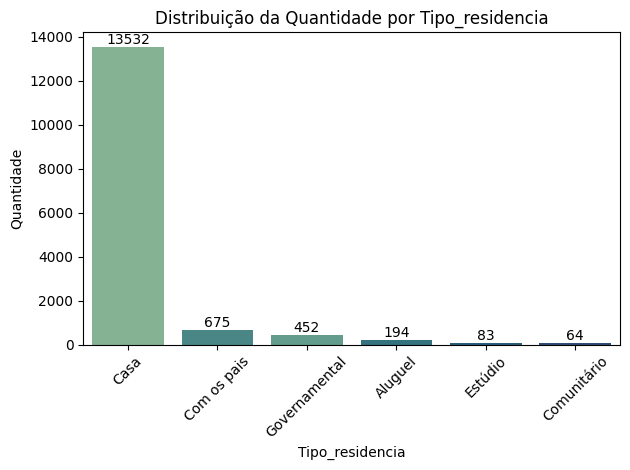

Porcentagem por categoria: 
 tipo_residencia
Casa             90.213333
Com os pais       4.500000
Governamental     3.013333
Aluguel           1.293333
Estúdio           0.553333
Comunitário       0.426667
Name: count, dtype: float64


In [300]:
countplot('tipo_residencia')

A categoria com maior quantidade é Casa (13532 registros, 90.2%), seguido de Com os pais (675 registros, 4.5%), Governamental (452 registros, 3%), Aluguel (194 registros, 1.3%), Estúdio (83 registros, 0.5%) e Comunitário (64 registros, 0.42%).

#### 4.2.2 Distribuição das variáveis quantitativas:

As variáveis utilizadas para análise univariada aqui serão:
- `qtd_filhos`
- `idade`
- `tempo_emprego`
- `qt_pessoas_residencia`

##### Distribuição da variável discreta `qtd_filhos`:

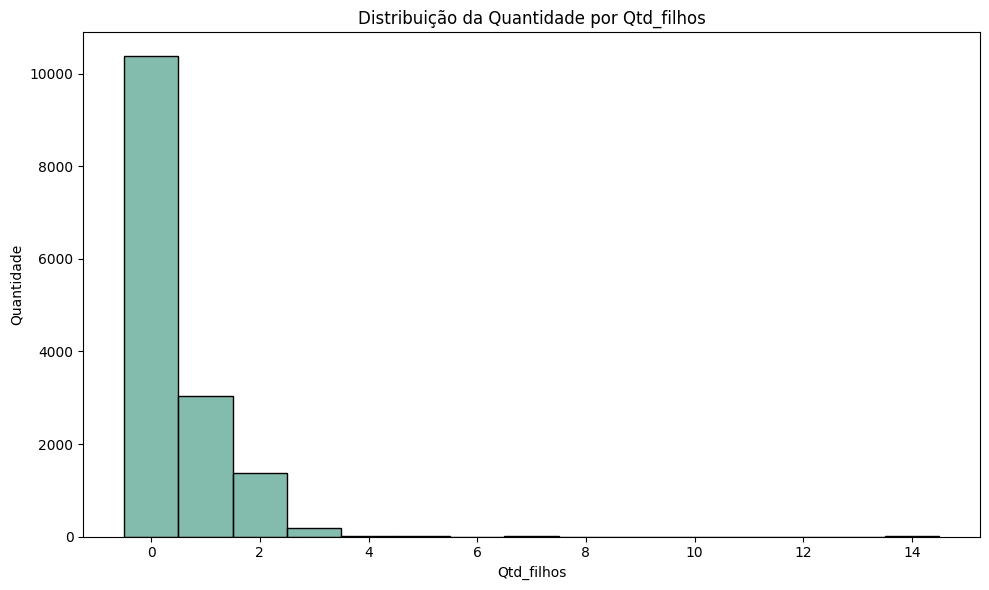

In [301]:
histplot('qtd_filhos')

Existe uma maior concentração de clientes com uma menor quantidade de filhos, sendo a maior parte deles com 0 filhos.

##### Distribuição da variável discreta `idade`:

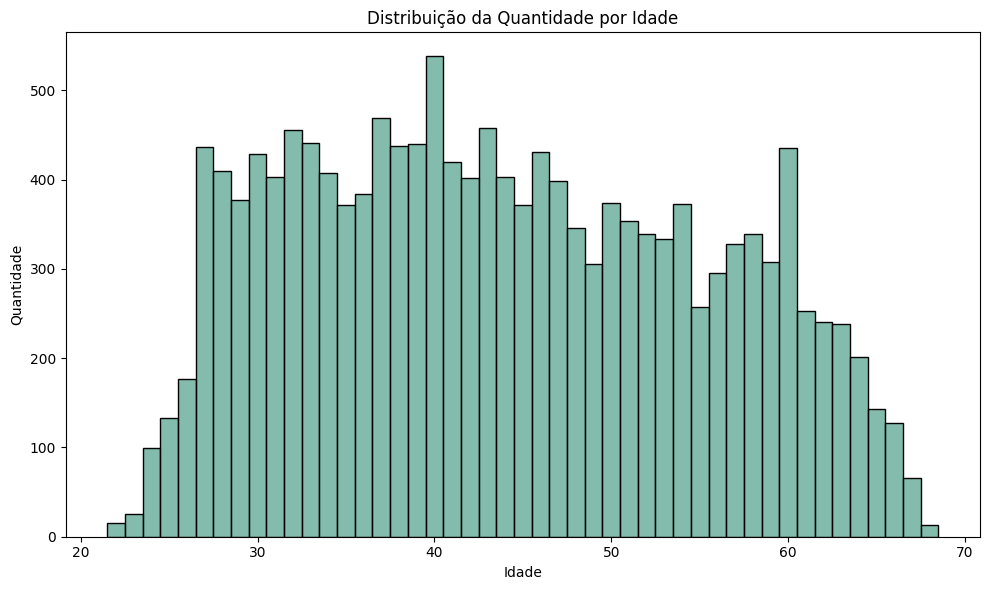

In [302]:
histplot('idade')

A idade apresenta uma distribuição semelhante a uma distribuição normal, com uma concentração mais elevada dos 30 aos 40 anos de idade.

##### Distribuição da variável contínua `tempo_emprego`:

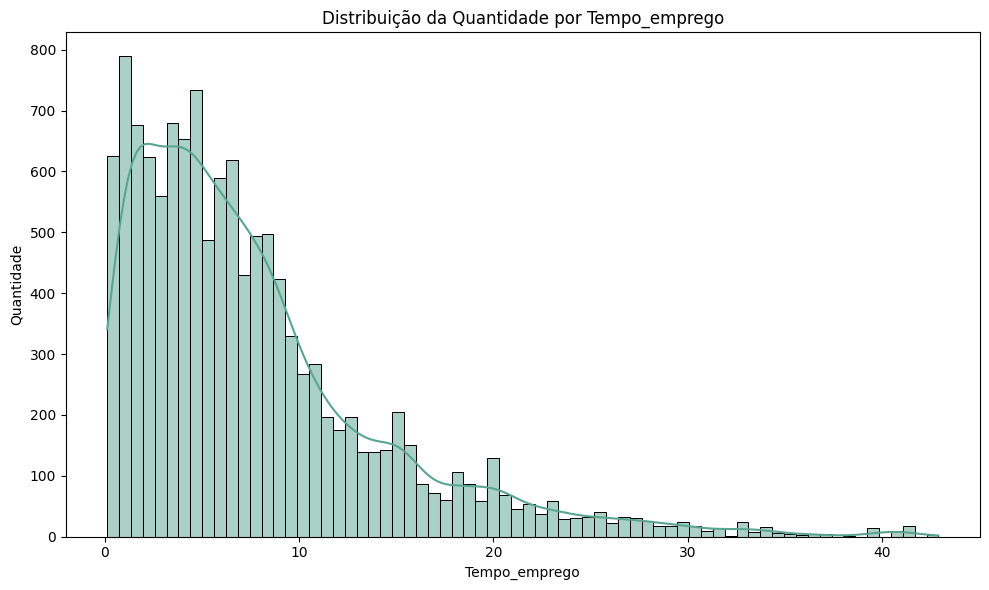

In [303]:
histplot('tempo_emprego')

O tempo emprego apresenta um decrescimento conforme o tempo aumenta, isso mostra que a maior parte dos clientes está concentrada na faixa abaixo de 10 anos. Apresenta caracteristica de escala logarítmica.

##### Distribuição da variável discreta `qt_pessoas_residencia`:

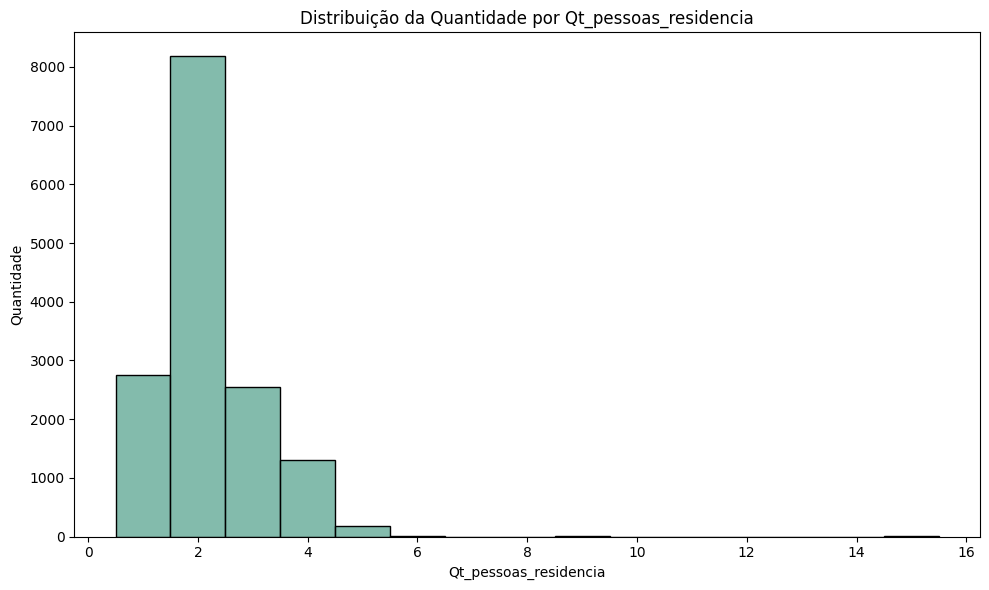

In [304]:
histplot('qt_pessoas_residencia')

A variável quantidade de pessoas na residência apresenta uma maior concetração nos clientes cadastrados com apenas 2 pessoas, com a concentração diminuindo conforme a quantidade de pessoas na residência aumenta.

### 4.3 Correlação entre as variáveis:



Nesta etapa será avaliada a distribuição das variáveis qualitativas em relação a variável alvo `renda`, e a correlação entre as variáveis quantitativas e a variável alvo `renda`.

Função para plotar gráficos para análise das variáveis booleanas:

In [305]:
#Gráfico pointplot
def point (var: str):
    '''Recebe uma variável booleana e retorna 
    um pointplot da Renda média em função da variável'''
    
    plt.figure(figsize=(10,6))
    sns.pointplot(data=renda,
                  x=var,
                  y='renda',
                  dodge=True,
                  errorbar=('ci', 95)
                  )
    plt.title(f'Renda Média em Função de {var}')
    plt.ylabel('Renda Média (R$)')

Função para plotar gráficos para análise das variáveis qualitativas:

In [306]:
#Gráfico barplot
def bar (var: str):
    '''Recebe uma variável qualitativa e retorna 
    um barplot da Renda média em função da variável'''
    
    plt.figure(figsize=(10,6))
    grb = renda.groupby(var)['renda'].mean().sort_values()
    ax = sns.barplot(hue=grb.index,
                     legend=True,
                     y=grb,
                     palette='crest'
                    )
    for i in range(renda[var].nunique()):
        ax.bar_label(ax.containers[i], fontsize=10)
    ax.set_title(f'Renda Média em função de {var}')
    ax.set_ylabel('Renda Média (R$)')
    ax.set_xlabel('Quantidade')

#### 4.3.1 Análise do potêncial preditivo das variáveis qualitativas em relação a renda média dos clientes:

##### Distribuição da variável `sexo` em relação a renda média:

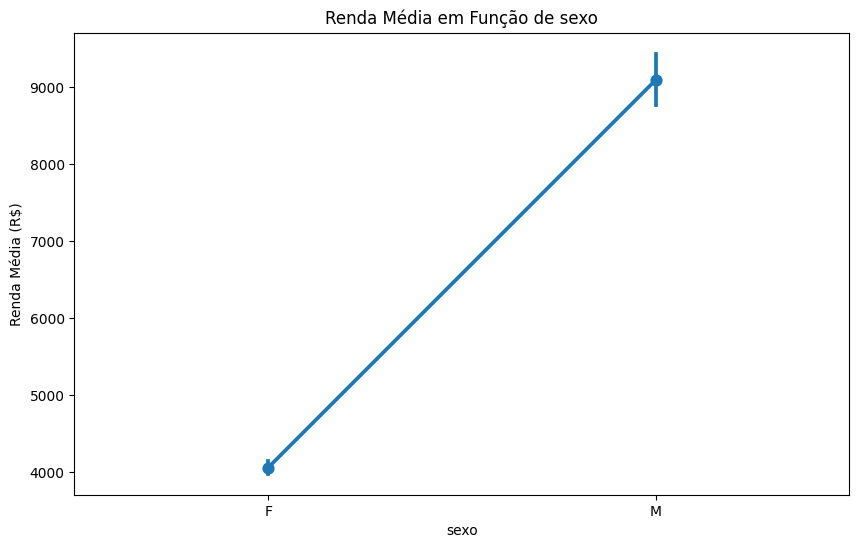

In [307]:
point('sexo')

A renda média se apresenta estatísticamente diferente para cada classe dentro da variável `sexo`, confirmando que a mesma apresenta potêncial preditivo. 

##### Distribuição da variável `posse_de_imovel` em relação a renda média:

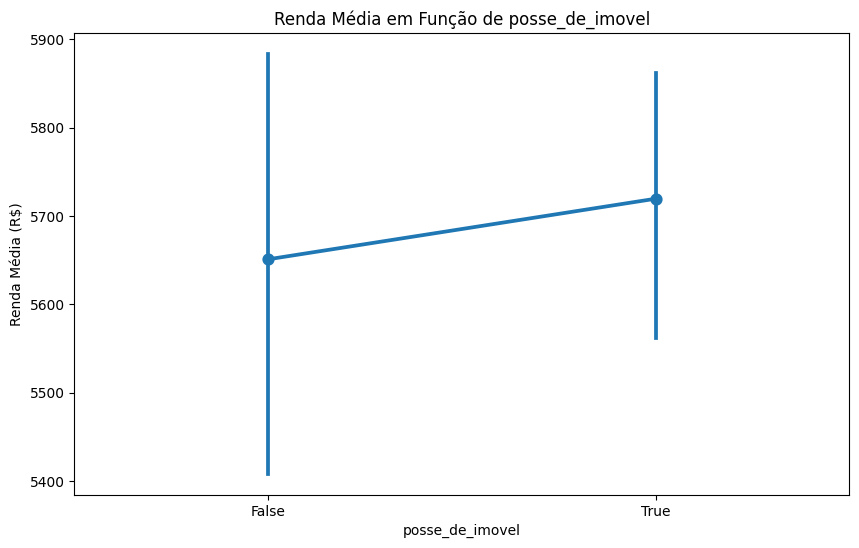

In [308]:
point('posse_de_imovel')

Não apresenta potencial preditivo, pois não é possível diferenciar a renda média utilizando a variável `posse_de_imovel`.

##### Distribuição da variável `posse_de_veiculo` em relação a renda média:

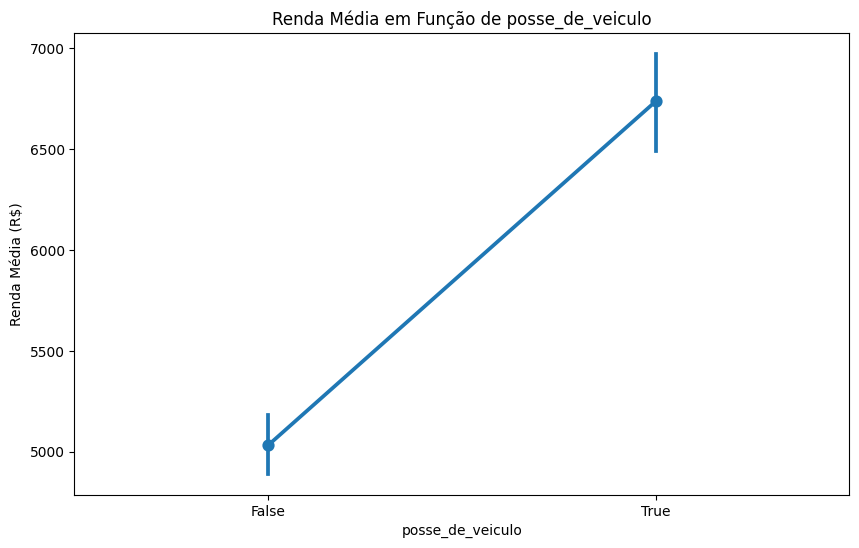

In [309]:
point('posse_de_veiculo')

A renda média é estatísticamente diferente para as diferentes classes da variável `posse_de_veiculo`. Apresentando um potencial preditivo para `renda`.

##### Distribuição da variável `tipo_residencia` em relação a renda média:

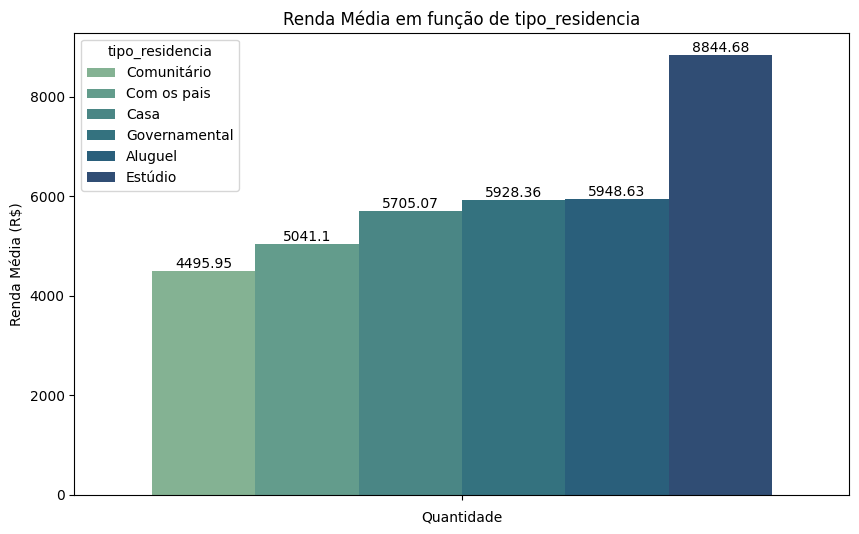

In [310]:
bar('tipo_residencia')

Apresenta diferentes valores de renda média para algumas classe. Já outras, apresentam uma diferença muito pequena para ser estatísticamente diferente, não apresentando um potencial preditivo tão grande.

##### Distribuição da variável `educacao` em relação a renda média:

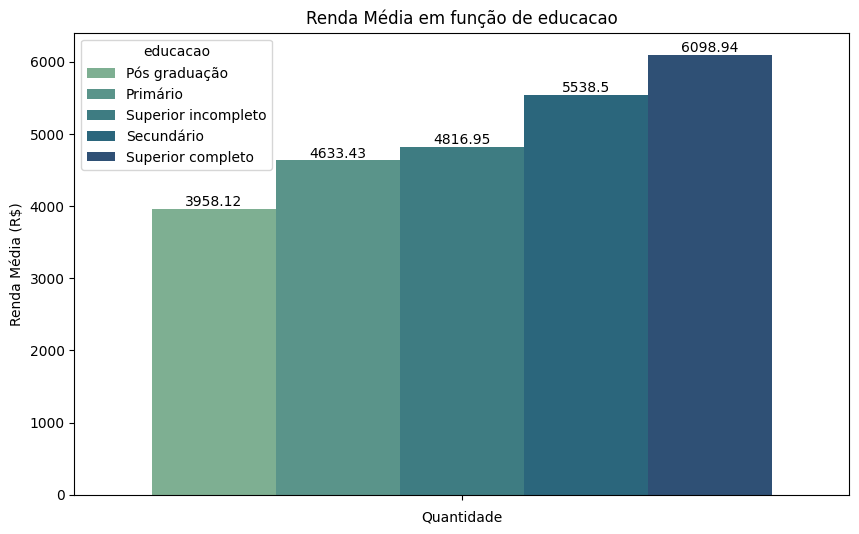

In [311]:
bar('educacao')

A variável `educacao` já apresenta uma diferença mais bem distribuída, contendo informações relevantes para a previsão da renda.

##### Distribuição da variável `estado_civil` em relação a renda média:

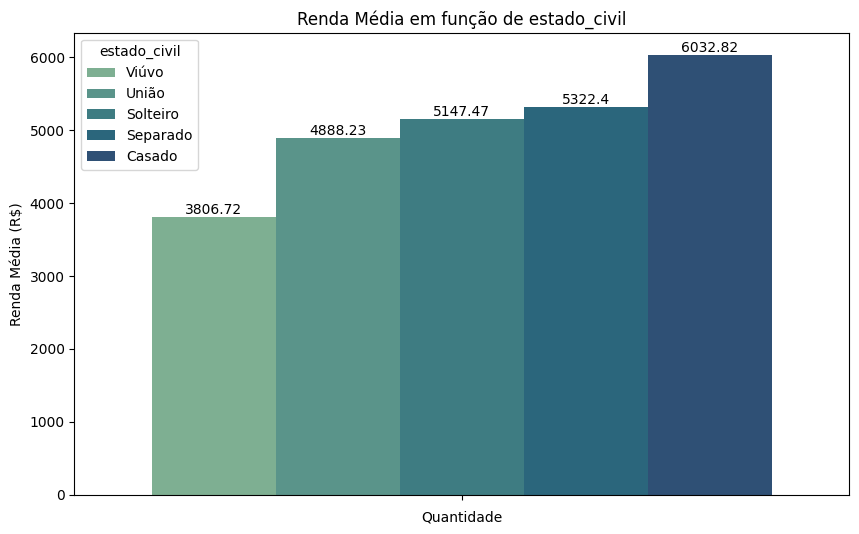

In [312]:
bar('estado_civil')

A variável `estado_civil` também apresenta uma diferença de classes bem distribuída. Contendo também informações relevantes para a predição.

##### Distribuição da variável `tipo_renda` em relação a renda média:

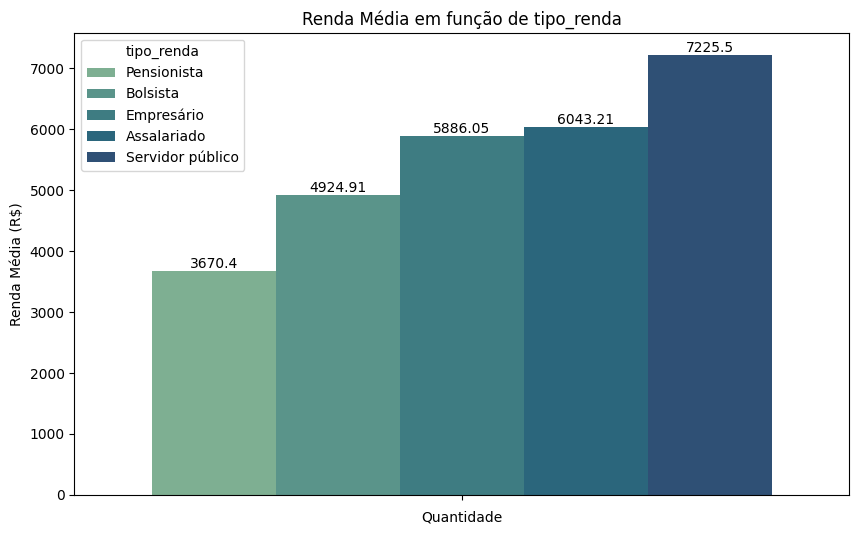

In [313]:
bar('tipo_renda')

A variável `tipo_renda` apresenta uma diferença um pouco mais marcante que as outras variáveis analisadas, contendo apenas duas classes com valores de renda média próximos. Sendo assim, também é uma variável com um potencial preditivo para `renda`.

Todas as variáveis categóricas analisadas apresentam diferenças nos valores médios para `renda`, algumas com mais e outras com menos, em diferentes classes de cada variável. Portanto, os dados categóricos contém infomações relevantes para a previsão da `renda`.

#### 4.3.2 Análise do potêncial preditivo das variáveis quantitativas em relação a renda:

A análise de qual variável apresenta o melhor potêncial preditivo será feita com base na correlação delas em relação a variável alvo renda.

##### Correlação das variáveis quantitativas:

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
qtd_filhos,1.000000,-0.360426,-0.063220,0.889777,0.029346
idade,-0.360426,1.000000,0.321573,-0.339320,0.022435
tempo_emprego,-0.063220,0.321573,1.000000,-0.065670,0.385013
qt_pessoas_residencia,0.889777,-0.339320,-0.065670,1.000000,0.047842
renda,0.029346,0.022435,0.385013,0.047842,1.000000


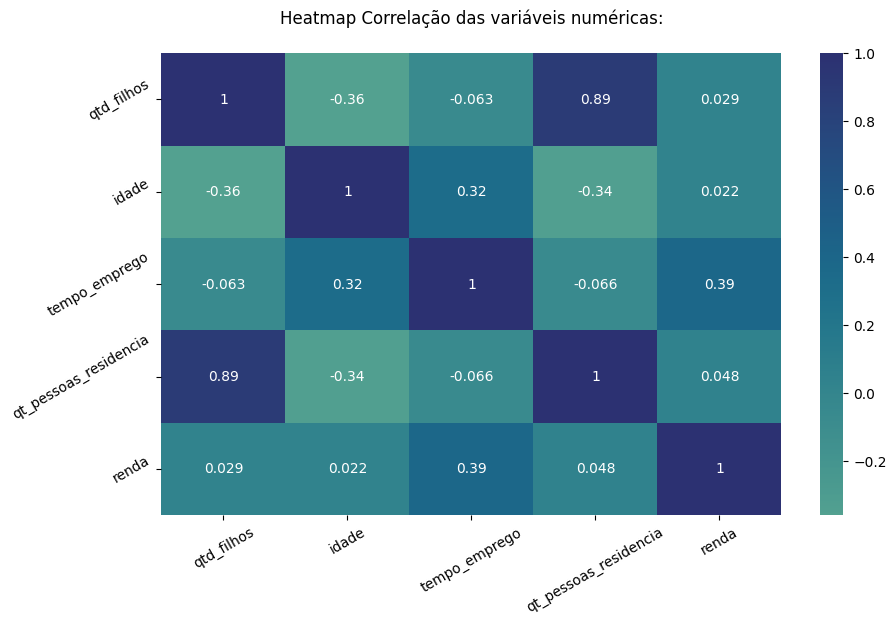

In [314]:
renda_num = list(renda.select_dtypes('number'))
plt.figure(figsize=(10,6))
plt.title('Heatmap Correlação das variáveis numéricas:\n')
sns.heatmap(renda[renda_num].drop(['Unnamed: 0', 'id_cliente'], axis=1).corr(),
               annot=True, 
               center = 0, 
               cmap='crest')
plt.xticks(rotation=30)
plt.yticks(rotation=30)
renda[renda_num].drop(['Unnamed: 0', 'id_cliente'], axis=1).corr()

Dentre as variáveis numéricas `tempo_emprego` é a que apresenta maior correlação com a variável alvo `renda`. Com cerca de 39% de correlação, apresenta um bom potencial preditivo.

A variável `tempo_emprego` tem correlação de 32% com `idade`. 

Já as outras variáveis apresentam baixa correlação com `renda`, variando de 2% a 4%.

Como a variável `tempo_emprego` é a que apresenta maior correlação com `renda`, vamos observar como ocorre a distribuição da `renda` em função de `tempo_emprego`, junto com a variável estatisticamente significativa `sexo`.

##### Análise da distribuição da variável `renda` em função da variável `tempo_emprego`:

Text(0.5, 1.0, 'Distruibuição da renda em função do tempo de emprego:')

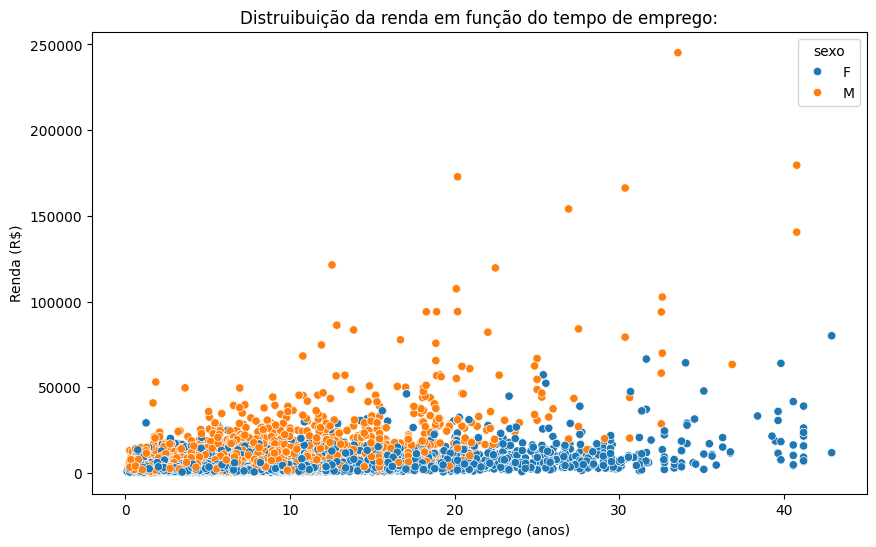

In [315]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=renda.dropna(),
                x='tempo_emprego',
                y='renda',
                hue='sexo'
                )
plt.ylabel('Renda (R$)')
plt.xlabel('Tempo de emprego (anos)')
plt.title('Distruibuição da renda em função do tempo de emprego:')

Como ilustrado no gráfico de distibuição acima, nota-se a correlação existente entre `renda` e `tempo_emprego`, já que a maior concentração de clientes está naqueles com pouco tempo de emprego e baixa renda, enquanto aqueles com um tempo de emprego maior se apresentam em menor quantidade e com rendas maiores.

Outra informação relevante possível de extrair do gráfico são valores de renda diferentes para o sexo masculino e feminino. Sendo as mulheres encontradas nas faixas mais baixas. Tal diferença indica que a variável `sexo` pode apresentar potencial preditivo sobre a `renda`.

### 4.4 Boxplot para identificar possíveis outliers:

Os boxplots gerados serão para as variáveis quantitativas, a variável alvo `renda` é deixada de fora pois apresenta característica logarítmica.

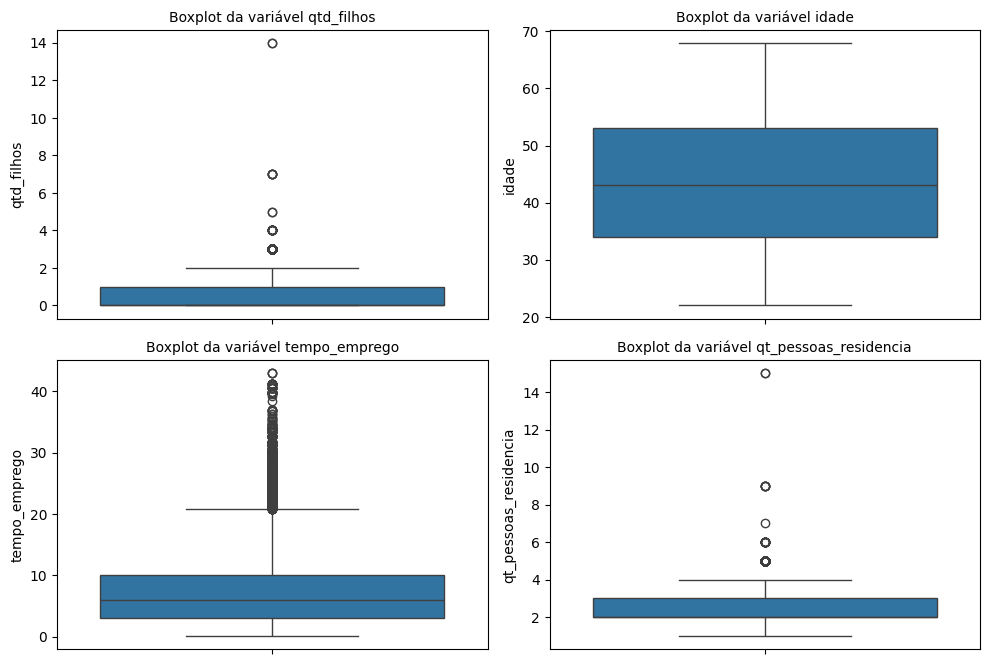

In [316]:
num_cols = renda.select_dtypes(include=['float64', 'int64']).drop(columns=['Unnamed: 0', 'id_cliente', 'renda']).columns

plt.figure(figsize=(10,10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3,2,i)
    sns.boxplot(y=renda[col])
    plt.title(f'Boxplot da variável {col}', fontsize=10)
    plt.tight_layout()

plt.show()

- `qtd_filhos`: Tem alguns outliers para cima, necessário realizar o capping.
- `idade`: Quase nenhum outlier, não é necessário tratamento.
- `tempo_emprego`: Muitos outliers para cima, como a sua distribuição observada nas seções anteriores apresenta característica logarítmica o tratamento adequado é a aplicação do log.
- `qt_pessoas_residencia`: Poucos outliers para cima, necessário realizar o capping.

## 5. Preparação dos dados:

Nessa etapa serão realizadas as seguintes operações com os dados:

 - **seleção**: Seleção dos dados adequadamente para que se encontrem em formatos úteis
 - **limpeza**:  Identificar e tratar dados faltantes, e tratar os outliers
 - **construção**: Construção de novas variáveis (dummies)
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?

### 5.1 Seleção:

Elimina as variáveis não úteis para a criação do modelo, mantendo somente aquelas que contém qualquer informação relevante.

In [317]:
renda.drop(['id_cliente', 'Unnamed: 0', 'data_ref'], axis=1, inplace = True)

In [318]:
renda.head(5)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


### 5.2 Limpeza:

#### 5.2.1 Identificação e tratamento de dados faltantes:

##### Análise dos dados faltantes dentro do DataFrame:

,tempo_emprego,porcentagem_tempo_emprego
faltantes,2573,17.15
sem_faltantes,12427,82.85
total,15000,100.00


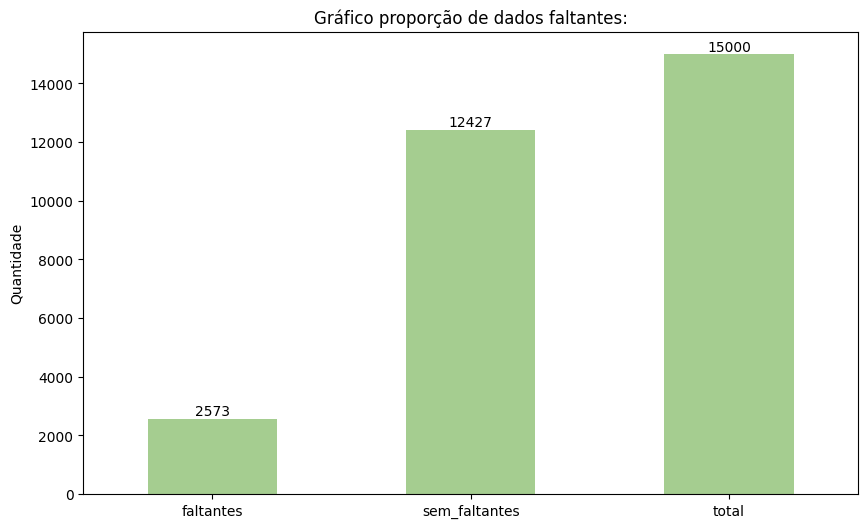

In [319]:
dados_faltantes_dict = {}

if renda.isna().any().sum()>0:
    
       for col in renda.columns:
           
            if renda[col].isna().any():
                
                perc = 'porcentagem' + f'_{col}'
                qnt = renda[renda[col].isna()].shape[0]
                total = renda.shape[0]
                sem_na = renda.dropna().shape[0]
                dic = {
                       col: {'faltantes': qnt, 
                             'sem_faltantes': sem_na,
                             'total': total},
                       
                       perc: {'faltantes': round(qnt/total*100, 2),
                              'sem_faltantes': round(sem_na/total*100, 2),
                              'total': 100}
                       }
                dados_faltantes_dict.update(dic)
else:
       print('Não há dados faltantes.')

if dados_faltantes_dict != {}:

       dados_faltantes = pd.DataFrame(dados_faltantes_dict)
       
       plt.figure(figsize=(10,6))
       ax = dados_faltantes.tempo_emprego.plot(kind='bar', colormap='crest')
       ax.set_title('Gráfico proporção de dados faltantes:')
       ax.set_ylabel('Quantidade')
       ax.tick_params(axis='x', rotation=0)
       ax.bar_label(ax.containers[0], fontsize=10)
       leg = plt.legend()
       ax.get_legend().remove()

dados_faltantes

Como ilustrado acima, a única variável que possui dados faltantes é `tempo_emprego`. Contendo 2573 dados faltantes, que correspondem a 17,15% dos dados preenchidos. Sendo esta uma pocentagem baixa, apenas exluí-los não irá afetar o restante dos dados.

Remoção dos dados faltantes da variável `tempo_emprego`:

In [320]:
renda.dropna(subset='tempo_emprego', inplace=True)

#### 5.2.2 Tratamento dos outliers:

##### Aplicação da função log nas variáveis necessárias:

In [321]:
renda_log = renda.copy()
renda_log['tempo_emprego_log'] = np.log(renda['tempo_emprego'] + 1)
renda_log['log_renda'] = np.log(renda['renda'])
renda_log.drop(columns=['tempo_emprego', 'renda'], inplace=True)
renda_log.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,qt_pessoas_residencia,tempo_emprego_log,log_renda
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,1.0,2.028509,8.994711
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,2.0,2.102127,7.524102
2,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,2.0,0.608872,7.720413
3,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,3.0,1.765856,8.794942
4,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,1.0,1.666414,8.775854


##### Aplicando a Regra do IQR (Interquatile Range) para realizar o capping:

Função para realização do capping:

In [322]:
def cap_outliers_iqr(df, col):
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=limite_inferior, upper=limite_superior)
    return df

Aplicando capping nas variáveis desejadas:

In [323]:
variaveis_para_capping = ['qtd_filhos', 'qt_pessoas_residencia']

for var in variaveis_para_capping:
    renda_log = cap_outliers_iqr(renda_log, var)

Análise dos dados após o tratamento:

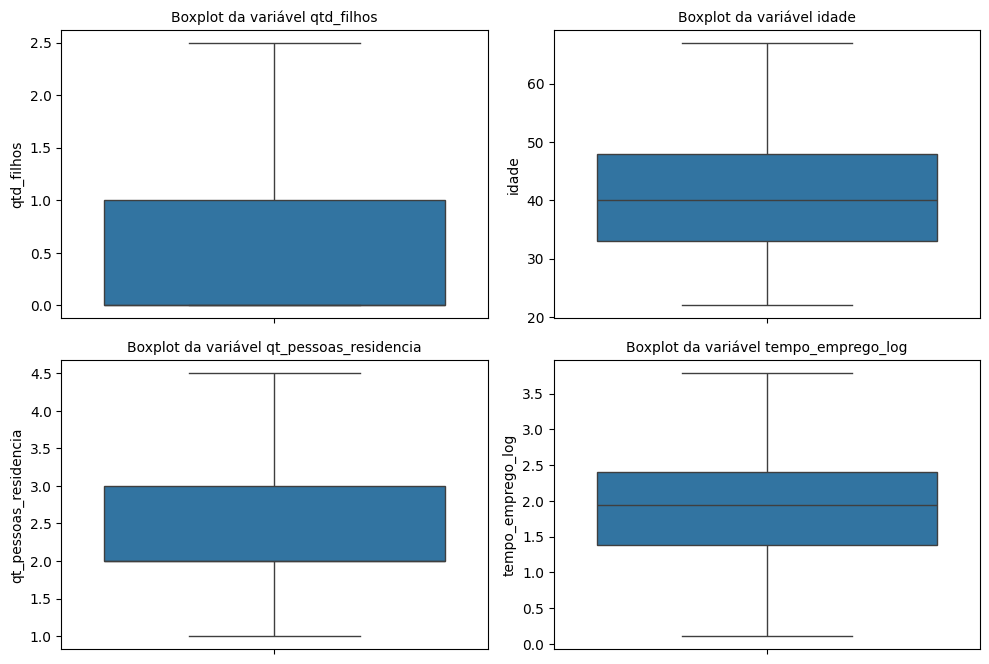

In [324]:
num_cols = renda_log.select_dtypes(include=['float64', 'int64']).drop(columns=['log_renda']).columns

plt.figure(figsize=(10,10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3,2,i)
    sns.boxplot(y=renda_log[col])
    plt.title(f'Boxplot da variável {col}', fontsize=10)
    plt.tight_layout()

plt.show()

Os dados estão deistribuidos de forma que não há nenhum outlier.

### 5.3 Construção:

Tratando as variáveis para um formato útil para a seleção delas e criação do modelo:

In [325]:
renda_log['sexo'] = renda_log['sexo'].map({'M': 1, 'F': 0})
renda_dummies = pd.get_dummies(renda_log, dtype=int)
renda_dummies[['posse_de_veiculo', 'posse_de_imovel']] = renda_dummies[['posse_de_veiculo', 'posse_de_imovel']].astype(int)

Pode-se observar que a criação de Dummies fez com que as variáveis assumissem caractéres não apropriados para a utilização em nomes de variáveis.

In [326]:
renda_dummies.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'qt_pessoas_residencia', 'tempo_emprego_log', 'log_renda',
       'tipo_renda_Assalariado', 'tipo_renda_Bolsista',
       'tipo_renda_Empresário', 'tipo_renda_Pensionista',
       'tipo_renda_Servidor público', 'educacao_Primário',
       'educacao_Pós graduação', 'educacao_Secundário',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel',
       'tipo_residencia_Casa', 'tipo_residencia_Com os pais',
       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio',
       'tipo_residencia_Governamental'],
      dtype='object')

### 5.4 Formatação:

Utilizando o método replace para tratar as variáveis.

In [327]:
col = renda_dummies.columns.to_list()
col_lower = []

for i in col:
    x = i.lower()
    y = x.replace('á', 'a')
    y = y.replace(' ', '_')
    y = y.replace('ã', 'a')
    y = y.replace('ú', 'u')
    y = y.replace('ó', 'o')
    col_lower.append(y)
    
renda_dummies.columns = col_lower

Agora as variáveis se encontram com os nomes em um formato adequado.

In [328]:
renda_dummies.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'qt_pessoas_residencia', 'tempo_emprego_log', 'log_renda',
       'tipo_renda_assalariado', 'tipo_renda_bolsista',
       'tipo_renda_empresario', 'tipo_renda_pensionista',
       'tipo_renda_servidor_publico', 'educacao_primario',
       'educacao_pos_graduaçao', 'educacao_secundario',
       'educacao_superior_completo', 'educacao_superior_incompleto',
       'estado_civil_casado', 'estado_civil_separado', 'estado_civil_solteiro',
       'estado_civil_uniao', 'estado_civil_viuvo', 'tipo_residencia_aluguel',
       'tipo_residencia_casa', 'tipo_residencia_com_os_pais',
       'tipo_residencia_comunitario', 'tipo_residencia_estudio',
       'tipo_residencia_governamental'],
      dtype='object')

Separando a base em treino e teste, para que assim seja possível fazer a avaliação das variáveis estatisticamente significativas.

In [329]:
X, y = renda_dummies.drop('log_renda', axis=1), renda_dummies['log_renda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23, shuffle=True)

## 6. Seleção de Variáveis:

Nesta etapa será feita a seleção das variáveis estatisticamente significativas.

- Primeiro filtrando com a ferramenta LassoCV
- Selecionando as mais importantes com RFE

### 6.1 LassoCV para a pré-seleção de features estatisticamente significativas:

In [330]:
lasso = LassoCV(cv=5, random_state=23).fit(X_train, y_train)
lasso_select = X_train.columns[lasso.coef_ != 0]
X_lasso = X_train[lasso_select]
print('Features selecionadas após LassoCV:')
for i in lasso_select:
    print(i)

Features selecionadas após LassoCV:
sexo
posse_de_veiculo
posse_de_imovel
qtd_filhos
idade
tempo_emprego_log
tipo_renda_assalariado
tipo_renda_empresario
educacao_secundario
educacao_superior_completo
estado_civil_casado


### 6.2 RFE para a seleção final das features estatisticamente significativas:

In [331]:
rfe_model = LinearRegression()
rfe = RFE(estimator=rfe_model, 
          n_features_to_select=8)
rfe.fit(X_lasso, y_train)
rfe_selected = X_lasso.columns[rfe.support_]
X_rfe = X_lasso[rfe_selected]

print('Features selecionadas após RFE:')
for i in rfe_selected:
    print(i)

Features selecionadas após RFE:
sexo
posse_de_imovel
tempo_emprego_log
tipo_renda_assalariado
tipo_renda_empresario
educacao_secundario
educacao_superior_completo
estado_civil_casado


### 6.3 Filtrando o DataFrame apenas com as features selecionadas:

Filtrando apenas as features selecionadas:

In [332]:
var_significativa = rfe_selected.to_list()
renda_significativa = renda_dummies[var_significativa]
renda_significativa.head()

,sexo,posse_de_imovel,tempo_emprego_log,tipo_renda_assalariado,tipo_renda_empresario,educacao_secundario,educacao_superior_completo,estado_civil_casado
0,0,1,2.028509,0,1,1,0,0
1,1,1,2.102127,1,0,0,1,1
2,0,1,0.608872,0,1,0,1,1
3,0,1,1.765856,0,0,0,1,1
4,1,0,1.666414,1,0,1,0,0


In [333]:
X = renda_significativa

Separando os dados em treino e teste para aplicação no modelo

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23, shuffle=True)

## 7. Modelagem:

Nessa etapa que realizaremos a construção do modelo.

- Selecionar a técnica de modelagem
- Otimização do modelo
- Seleção dos melhores hiperparametros
- Treino do modelo

Neste projeto será utilizado o Gradient Boosting Machine. Como o objetivo é realizar a previsão da renda, que é uma variável quantitativa contínua, será utilizada uma estrutura de regressão. No caso o GradientBoostingRegressor.

Para um melhor desempenho do modelo, iremos buscar os melhores hiperparametros para o modelo através do Optuna, com a métrica de avaliação RMSE, MAE e R², e também será testado o RandomizedSeachCV. Isso faz com que o modelo treinado não se ajuste tanto aos dados ficando mais robusto a overffiting.

### 7.0. Treinamento inicial:

Função para avaliação das métricas:

In [267]:
def avaliar_regressao(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''Avalia um modelo de regressão e retorna um DataFrame com métricas para treino e teste'''
    y_pred_train = np.exp(model.predict(X_train))
    y_pred_test = np.exp(model.predict(X_test))
    y_train, y_test = np.exp(y_train), np.exp(y_test)
    metrics = {
        'RMSE' : [
            root_mean_squared_error(y_train, y_pred_train),
            root_mean_squared_error(y_test, y_pred_test)
                  ],
        'MAE' : [
            mean_absolute_error(y_train, y_pred_train),
            mean_absolute_error(y_test, y_pred_test)
                ],
        'R²' : [
            round(r2_score(y_train, y_pred_train), 3),
            round(r2_score(y_test, y_pred_test), 3)
               ]
    }
    
    df_metrics = pd.DataFrame(metrics, index=['Treino', 'Teste']).T
    return df_metrics

In [268]:
gbr = GradientBoostingRegressor(random_state=23)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=23)

In [269]:
avaliar_regressao(gbr)

,Treino,Teste
RMSE,6711.959549,6684.684293
MAE,3125.388082,3127.133698
R²,0.437000,0.418000


O valor de `RSME` para treino e teste são semelhantes e ambos altos, para a métrica `MAE` os valores também são semelhantes e altos, o mesmo se aplica para o $R^2$. Portanto, a partir das técnicas mencionadas acima, faremos a busca dos melhores hiperparametros a fim de melhorar as métricas e a capacidade de previsão do modelo.

### 7.1. Otimizações com Optuna, RandomizedSearchCV e GridSearchCV:

#### 7.1.1. Otimização do modelo com Optuna:

##### Optuna com a métrica RMSE:

Utilização do optuna para encontrar os hiperparametros que minimizem a raiz do erro médio quadrático (RMSE)

Função de otimização:

In [248]:
def objective_rmse(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 300, 800)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    subsample = trial.suggest_float('subsample', 0.7, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=23
    ).fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse 

In [249]:
study_min = optuna.create_study(direction='minimize')  
study_min.optimize(objective_rmse, n_trials=75)

[I 2025-04-27 17:52:43,445] A new study created in memory with name: no-name-0812d123-1266-4329-9160-fde3ad001b51
[I 2025-04-27 17:52:45,968] Trial 0 finished with value: 0.6970654631831114 and parameters: {'n_estimators': 790, 'learning_rate': 0.09788084857077649, 'max_depth': 3, 'subsample': 0.9825073061078524, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6970654631831114.
[I 2025-04-27 17:52:48,132] Trial 1 finished with value: 0.6949521242896375 and parameters: {'n_estimators': 366, 'learning_rate': 0.016747815677519436, 'max_depth': 7, 'subsample': 0.8243653842398911, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6949521242896375.
[I 2025-04-27 17:52:51,934] Trial 2 finished with value: 0.6848589784703281 and parameters: {'n_estimators': 751, 'learning_rate': 0.08904681076875459, 'max_depth': 5, 'subsample': 0.7772458431097673, 'min_samples_split': 12, 'min_samples_le

In [252]:
best_optuna_rmse = study_min.best_params
print(f'Melhores parâmetros: {best_optuna_rmse}')

Melhores parâmetros: {'n_estimators': 456, 'learning_rate': 0.021792126976697423, 'max_depth': 8, 'subsample': 0.7457255204396513, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}


##### Optuna com a métrica $R^2$:

Utilização do optuna para encontrar os hiperparametros que maximizem o valor do $R^2$

Função de otimização:

In [ ]:
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 300, 800)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    subsample = trial.suggest_float('subsample', 0.7, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=23
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=75)

[I 2025-04-27 17:35:34,508] A new study created in memory with name: no-name-6b29988e-4be3-4f4f-b4c6-9906bf56cf0d
[I 2025-04-27 17:35:49,114] Trial 0 finished with value: 0.38551584140853007 and parameters: {'n_estimators': 773, 'learning_rate': 0.02577946055213575, 'max_depth': 6, 'subsample': 0.7317322133020491, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.38551584140853007.
[I 2025-04-27 17:36:07,243] Trial 1 finished with value: 0.35938860935243 and parameters: {'n_estimators': 536, 'learning_rate': 0.07920731736156539, 'max_depth': 8, 'subsample': 0.8261595940874639, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.38551584140853007.
[I 2025-04-27 17:36:22,203] Trial 2 finished with value: 0.40086376760422626 and parameters: {'n_estimators': 642, 'learning_rate': 0.04745982118411694, 'max_depth': 5, 'subsample': 0.7788635371710929, 'min_samples_split': 8, 'min_samples_leaf'

In [253]:
best_optuna_r2 = study.best_params
print(f'Melhores parâmetros: {best_optuna_r2}')

Melhores parâmetros: {'n_estimators': 562, 'learning_rate': 0.025979202751039793, 'max_depth': 7, 'subsample': 0.9420082771729126, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


##### Optuna com a métrica MAE:

Utilização do optuna para encontrar os hiperparametros que minimizem o erro médio absolito (MAE)

Função de otimização:

In [259]:
def objective_mae(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 300, 800)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    subsample = trial.suggest_float('subsample', 0.7, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=23
    ).fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae 

In [260]:
study_mae = optuna.create_study(direction='minimize')  
study_mae.optimize(objective_mae, n_trials=75)

[I 2025-04-27 18:27:01,310] A new study created in memory with name: no-name-b2ee1eda-2f1e-4d17-a732-abe15e28f706
[I 2025-04-27 18:27:08,097] Trial 0 finished with value: 0.543623355406732 and parameters: {'n_estimators': 622, 'learning_rate': 0.030447204408558463, 'max_depth': 5, 'subsample': 0.970415934160156, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.543623355406732.
[I 2025-04-27 18:27:11,051] Trial 1 finished with value: 0.5495907714597119 and parameters: {'n_estimators': 537, 'learning_rate': 0.03655487961183851, 'max_depth': 7, 'subsample': 0.80838369442693, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 0 with value: 0.543623355406732.
[I 2025-04-27 18:27:13,946] Trial 2 finished with value: 0.5554833047345384 and parameters: {'n_estimators': 769, 'learning_rate': 0.03236728369245096, 'max_depth': 3, 'subsample': 0.9799543022548225, 'min_samples_split': 2, 'min_samples_leaf': 6, 'm

In [261]:
best_optuna_mae = study.best_params
print(f'Melhores parâmetros: {best_optuna_mae}')

Melhores parâmetros: {'n_estimators': 562, 'learning_rate': 0.025979202751039793, 'max_depth': 7, 'subsample': 0.9420082771729126, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


#### 7.1.2. Otimização do modelo com RandomizedSeachCV:

In [226]:
gbm = GradientBoostingRegressor(random_state=23)

param_dist = {
    'n_estimators': randint(300, 800),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(estimator=gbm,
                    param_distributions=param_dist,
                    n_iter=100,
                    cv=5,
                    scoring='r2',
                    verbose=1,
                    n_jobs=-1
                    )
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=23),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AA4DF5A0C0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AA4DF5BDA0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'mi...frozen object at 0x000002AA4DF349E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AA4DF36F30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AA4DEFF9B0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AA4DF5B4A0>},
                   scoring='r2', verbose=1)

In [250]:
best_random = random_search.best_params_
print(f'Melhores parametros: {best_random}')


Melhores parametros: {'learning_rate': 0.034166952145254316, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 746, 'subsample': 0.9135332641500861}


#### 7.1.3. Otimização do modelo com GridSearchCV:

In [263]:
gbr = GradientBoostingRegressor(random_state=23)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(estimator=gbr, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1
                           ).fit(X_train, y_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


In [265]:
best_grid = grid_search.best_params_
print(f'Melhores parametros: {best_grid}')

Melhores parametros: {'learning_rate': 0.01, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.8}


### 7.2. Seleção dos melhores hiperparametros:

Para a seleção dos melhores hiperparametros para o modelo, vamos avaliar as métricas `R²`, `RMSE` e `MAE`.

#### 7.2.1. Avaliação das métricas:

##### Métricas para Optuna que minimiza o RMSE:

In [255]:
gbr_rmse = GradientBoostingRegressor(**best_optuna_rmse, random_state=23).fit(X_train, y_train.ravel())
avaliar_regressao(gbr_rmse)

,Treino,Teste
RMSE,5324.803927,6264.090807
MAE,2531.434996,2981.194927
R²,0.646000,0.489000


Apresenta boas métricas com um valor mais elevado de `R²` tanto para treino quanto para teste, com uma amplitude entre eles de 0.15. As métricas `RMSE` e `MAE` tiveram seus valores reduzidos, o que é bom, pois mostra que o modelo apresenta menos erro e uma variância de erros menor.

##### Métricas para o Optuna que maximiza o R²:

In [256]:
gbr_rsqr = GradientBoostingRegressor(**best_optuna_r2, random_state=23).fit(X_train, y_train.ravel())
avaliar_regressao(gbr_rsqr)

,Treino,Teste
RMSE,5326.230124,6364.454571
MAE,2519.485109,2968.599207
R²,0.645000,0.472000


Também apresenta boas métricas, porém com um valor de `R²` menor e `RMSE` maior que o modelo anterior, tanto para treino, quanto para teste. Portanto, não são os melhores parâmetros.

##### Métricas para o Optuna que minimiza o MAE:

In [262]:
gbr_mae = GradientBoostingRegressor(**best_optuna_mae, random_state=23).fit(X_train, y_train.ravel())
avaliar_regressao(gbr_mae)

,Treino,Teste
RMSE,5326.230124,6364.454571
MAE,2519.485109,2968.599207
R²,0.645000,0.472000


Possui um valor de `R²` inferior e um `RMSE` superior ao modelo que minimiza o `RMSE`. Portanto não são os melhores parâmetros.

##### Métricas para o RandomizedSearchCV:

In [257]:
gbr_random = GradientBoostingRegressor(**best_random, random_state=23).fit(X_train, y_train.ravel())
avaliar_regressao(gbr_random)

,Treino,Teste
RMSE,4929.655664,6275.173074
MAE,2323.076465,2939.913426
R²,0.696000,0.487000


Apresenta um bom valor de `R²` para teste, porém o valor elevado para treino pode indicar um overfiting. Portanto, não são os melhores parâmetros.

##### Métricas para o GridSearchCV:

In [266]:
gbr_grid = GradientBoostingRegressor(**best_grid, random_state=23).fit(X_train, y_train.ravel())
avaliar_regressao(gbr_grid)

,Treino,Teste
RMSE,5807.706907,6439.599676
MAE,2777.400597,3034.674003
R²,0.578000,0.460000


Apesar da diferença do `R²` ser a mais baixa entre treino e teste, os valores também são os mais baixos para essa métrica. Já para as outras métricas `RMSE` e `MAE` os valores são superiores a todos os modelos ajustados com os parâmetros anteriores.

#### 7.2.2. Melhores métricas:

Portanto aquele que apresentou as melhores métrica e consequentemente os melhores parâmetros são os selecionados com o Optuna minimizando o `RMSE`.

In [271]:
best_optuna_rmse

{'n_estimators': 456,
 'learning_rate': 0.021792126976697423,
 'max_depth': 8,
 'subsample': 0.7457255204396513,
 'min_samples_split': 9,
 'min_samples_leaf': 1,
 'max_features': None}

### 7.5. Treinamento do modelo:

De acordo com os hiperparametros selecionados, afim de obter o melhor desempenho possível para o modelo, o treinamento do mesmo será feito baseado nos mesmos.

In [274]:
gbr = GradientBoostingRegressor(**best_optuna_rmse, random_state=23)
gbr.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.021792126976697423, max_depth=8,
                          min_samples_split=9, n_estimators=456,
                          random_state=23, subsample=0.7457255204396513)

## 8. Avaliação dos resultados:

### 8.1. Avaliação das métricas do modelo final criado:

In [335]:
avaliar_regressao(gbr)

,Treino,Teste
RMSE,5324.803927,6264.090807
MAE,2531.434996,2981.194927
R²,0.646000,0.489000


O modelo treinado apresenta um R² de 0.646 para o conjunto de dados de treino e 0.489 para testes, com uma amplitude de apenas 0.15 mostra que o modelo não possuí overfiting e consegue prever com uma precisão de 49% dos dados. Para a raiz do erro quadratico médio e o erro médio absoluto, vemos que os valores se elevam quando comparado os resultados de treino com os de teste, porém não apresenta uma amplitude significativa. Portanto o modelo ajustado possuí boa capacidade preditiva.

### 8.2. Visualização dos dados previstos com relação aos reais:

In [337]:
y_pred = np.exp(gbr.predict(X_test))
y_test_exp = np.exp(y_test)

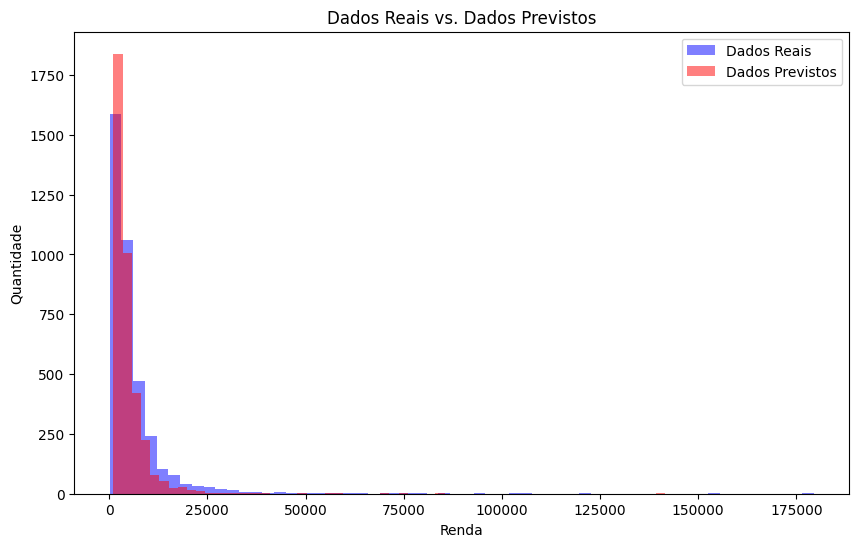

In [365]:
plt.figure(figsize=(10, 6))

sns.histplot(y_test_exp, bins=60, alpha=0.5, label='Dados Reais', color='blue', edgecolor='none')

sns.histplot(y_pred, bins=60, alpha=0.5, label='Dados Previstos', color='red', edgecolor='none')

plt.title('Dados Reais vs. Dados Previstos')
plt.xlabel('Renda')
plt.ylabel('Quantidade')

plt.legend()

plt.show()

O modelo apresenta boa capacidade preditiva, pois os dados previstos se assemelham aos dados reais observados acima.

### 8.3. Visualização dos resíduos do modelo:

Para os resíduos do modelo, quanto mais próxima a sua distribuição for de zero melhor o modelo desempenha.

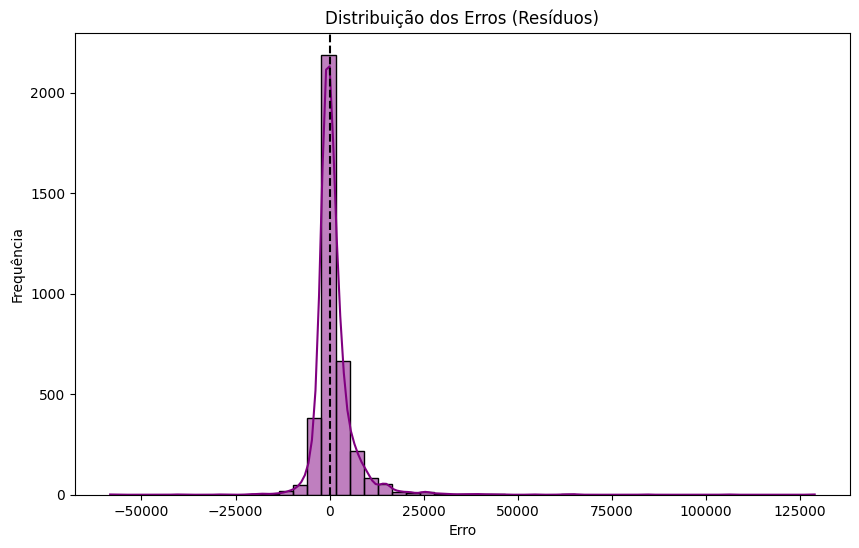

In [366]:
erro = y_test_exp - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(erro, bins=50, kde=True, color='purple')

plt.title('Distribuição dos Erros (Resíduos)')
plt.xlabel('Erro')
plt.ylabel('Frequência')

plt.axvline(0, color='black', linestyle='--')

plt.show()

O gráfico acima ilustra uma distribuição bem próxima ao zero com pequenas fugas para os lados. Como a maior faixa de frequência se encontra em cima do zero, mostra que o modelo está com um bom desempenho.

## 9. Possível Implementação:

Como a previsão de renda é comumente utilizada por instituições financeiras finalidades como limite de crédito, valor previsto de emprestimo e muitas outras aplicações, a função abaixo cria classes de limite de crédito, tipo de cartão e valor de emprestimo para cada valor diferente de renda prevista.

Claro que tais itens são definidos utilizando muitas outras variáveis, como a relação com outras instiuições financeiras, se o cliente é inadimplente, posse de bens e mais outras que forem necessárias para a determinação dos mesmos. Mas para efeitos de visualização, foi utilizado apenas a variável renda. 

O cálculo do valor do emprestimo foi feito com base na renda. Calculado para que seja pago em 24x, com o valor de cada parcela não ultrapassando cerca de 30% da renda total prevista, somando assim o montante final.

A função desenvolvida em Python integra o modelo de machine learning treinado com o Gradient Boosting Machine. A função recebe um conjunto de dados, realiza a previsão da renda dos clientes e, com base nos valores previstos, classifica automaticamente cada cliente em faixas de limite de crédito, categoria de cartão e valor de empréstimo pré-aprovado. 

A função foi construída de forma modular, com tratamento de exceções para garantir robustez e flexibilidade para ajustes de faixas de classificação, possibilitando futuras atualizações conforme a necessidade do negócio.

#### Função de classificação de crédito:

In [380]:
def prever_renda(df: pd.DataFrame, modelo, limites=None):
    '''
    Função para prever renda e classificar limites de crédito e empréstimos.
    
    Parâmetros:
    - df: DataFrame contendo as features para previsão
    - modelo: modelo de machine learning treinado
    - limites: dicionário opcional com faixas de classificação
    
    Retorna:
    - DataFrame com previsões e classificações
    '''
    if df.empty:
        raise ValueError('O DataFrame de entrada está vazio.')
    
    if limites is None:
        limites = {
            2500: ('standard', 3000, 18000),
            4000: ('gold', 6000, 36000),
            6000: ('platinum', 10000, 54000),
            15000: ('black', 15000, 72000),
            25000: ('black', 20000, 100000),
            float('inf'): ('black', 25000, 150000)
        }
        
    renda_prevista = np.exp(modelo.predict(df))
    classificacoes = []
    
    for renda in renda_prevista:
        for limite, (classe, credito, emprestimo) in limites.items():
            if renda <= limite:
                classificacoes.append({
                    'renda_prevista': renda,
                    'limite_de_credito': credito,
                    'classe_cartao': classe,
                    'emprestimo_concedido': emprestimo
                })
                break
    return pd.DataFrame(classificacoes)

#### DataFrame com as previsões e classificações:

In [381]:
prever_renda(X_test, gbr)

,renda_prevista,limite_de_credito,classe_cartao,emprestimo_concedido
0,1866.722763,3000,standard,18000
1,4139.193350,10000,platinum,54000
2,5308.783479,10000,platinum,54000
3,3148.537755,6000,gold,36000
4,9912.363876,15000,black,72000
...,...,...,...,...
3724,2691.127404,6000,gold,36000
3725,13429.001890,15000,black,72000
3726,3222.947593,6000,gold,36000
3727,3379.622888,6000,gold,36000


Dentro da capacidade do modelo criado ele consegue prever a renda dos clientes com base nas features selecionadas, podendo gerar aplicações úteis como o exemplo acima. No qual de acordo com a previsão de renda feita pelo modelo foi possível classificar o cliente em limite de crédito, tipo de cartão e limite de emprestimo.

## 10. Conclusão:

A partir do EDA (capítulo 4), podemos extrair informações relevantes e importantes sobre os dados. Como a característica logarítmica da variável alvo `renda` e também da variável preditiva `tempo_emprego`, tratando-as com a aplicação da função log é possível criar uma relação linear entre elas e outras variáveis explicativas.

Pode-se destacar a diferença salarial apresentada para clientes do sexo feminino e masculino, com maior parte das mulheres com salários menores. Tal questão se deve a problemas enraizados em nossa sociedade.

As varíaveis utilizadas para a modelagem foram:
- `sexo`
- `posse_de_imovel`
- `tempo_emprego_log`
- `tipo_renda_assalariado`
- `tipo_renda_empresario`
- `educacao_secundario`
- `educacao_superior_completo`
- `estado_civil_casado`

Sendo as variáveis `tempo_emprego` e `sexo` as com maior importância para a previsão.

O modelo foi criado utilizando o Gradient Boosting Machine, com GradientBoostingRegressor. Tendo seus hiperparametros ajustados utilizando o optima, em que minimiza o valor da raiz do erro médio quadrático para encontrar a melhor combinação possível.

O modelo possuí as seguintes métricas para a previsão:
- `RMSE`: 6264.09
- `MAE`: 2981.16
- `R²`: 0.489

O valor de `RMSE` diz que quando o modelo erra a previsão o valor, ele está errando em média R$ 6262.09 da renda real. Enquanto o `MAE` trata todos os erros de maneira uniforme, não penalizando os erros grandes como o `RMSE`.

Já o `R²` mostra a capacidade do modelo de explicar os dados, portanto o modelo treinado é capaz de explicar 49% dos dados.